<a href="https://colab.research.google.com/github/TheCaveOfAdullam/Bethel/blob/main/Motor_5_5kw_ChPrune_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch_pruning
!pip install ptflops
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch_pruning as tp
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import time

In [ ]:
seed = 71
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # GPU 사용 시
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# 기본 경로 설정
base_dir = '/content/drive/MyDrive/motor_5.5kw_ver5'
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드 및 전처리
class VibrationDataset(Dataset):
    def __init__(self, base_dir, split, categories, label_encoder, segment_length=4000, transform=None):
        self.X = []
        self.y = []
        self.transform = transform
        self.segment_length = segment_length
        self.file_count = defaultdict(int)

        split_dir = os.path.join(base_dir, split)
        for category in categories:
            category_dir = os.path.join(split_dir, category)
            files = os.listdir(category_dir)
            self.file_count[category] = len(files)

            for file in files:
                file_path = os.path.join(category_dir, file)
                data = pd.read_csv(file_path, header=None, skiprows=1)
                frequency_data = data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0).values
                num_segments = frequency_data.shape[0] // self.segment_length
                for i in range(num_segments):
                    segment = frequency_data[i * self.segment_length:(i + 1) * self.segment_length]
                    self.X.append(segment)
                    self.y.append(label_encoder.transform([category])[0])

        print(f"File count for '{split}' split:")
        for category, count in self.file_count.items():
            print(f"  {category}: {count} files")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx].T
        y = self.y[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# 레이블 인코딩
label_encoder = LabelEncoder()
label_encoder.fit(categories)

# 데이터셋 준비
train_dataset = VibrationDataset(base_dir, 'train', categories, label_encoder)
val_dataset = VibrationDataset(base_dir, 'validation', categories, label_encoder)
test_dataset = VibrationDataset(base_dir, 'test', categories, label_encoder)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

first_sample, _ = train_dataset[0]
input_length = first_sample.shape[1]
print(f"Input length for one sample: {input_length}")

File count for 'train' split:
  normal: 2100 files
  fault_BB: 2100 files
  fault_RI: 2100 files
  fault_SM: 2100 files
File count for 'validation' split:
  normal: 450 files
  fault_BB: 450 files
  fault_RI: 450 files
  fault_SM: 450 files
File count for 'test' split:
  normal: 450 files
  fault_BB: 450 files
  fault_RI: 450 files
  fault_SM: 450 files
Input length for one sample: 4000


In [ ]:
# CNN 모델 정의
class CNNModel(nn.Module):
    def __init__(self, input_length):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=16, stride=16)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        with torch.no_grad():
            sample_input = torch.zeros(1, 1, input_length)
            sample_output = self.forward_conv_layers(sample_input)
            conv_output_size = sample_output.size(1) * sample_output.size(2)

        self.fc1 = nn.Linear(conv_output_size, 5000)
        self.fc2 = nn.Linear(5000, 1000)
        self.fc3 = nn.Linear(1000, len(categories))

    def forward_conv_layers(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.pool2(torch.relu(self.conv4(x)))
        return x

    def forward(self, x):
        x = self.forward_conv_layers(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# 모델 학습 함수 (학습 곡선 기록 추가)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, max_norm=1.0):
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_loader_iter.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # 학습 곡선 시각화
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    return model

# 모델 평가 함수
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()  # 배치 손실의 합
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 평균 손실은 배치 개수로 나눔
    average_val_loss = val_loss / len(loader)  # len(loader)는 배치 개수
    val_accuracy = 100 * correct / total

    return average_val_loss, val_accuracy

In [ ]:
def calculate_mean_gradients(model, dataloader, device, criterion):
    mean_gradients = {}
    model.train()  # 기울기 계산을 위해 train 모드로 설정

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d):
            # 기울기를 저장할 리스트 초기화
            channel_gradients = []

            def hook_fn(grad):
                # 채널별로 기울기의 절댓값 평균을 계산하여 저장
                grad = grad.detach().cpu().numpy()
                channel_mean_grad = np.mean(np.abs(grad), axis=(1, 2))
                channel_gradients.append(channel_mean_grad)

            # 가중치에 대한 hook 등록
            hook = module.weight.register_hook(hook_fn)

            # 데이터셋에 대한 순전파 및 역전파 수행
            for inputs, targets in dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                model.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()

            # hook 제거
            hook.remove()

            # 채널별 평균 기울기 계산
            mean_gradient = np.mean(channel_gradients, axis=0)
            mean_gradients[name] = mean_gradient

    return mean_gradients

In [ ]:
def prune_model_based_on_mean_gradient(model, mean_gradients, prune_ratio=0.2, example_inputs=None):
    device = next(model.parameters()).device
    if example_inputs is None:
        example_inputs = torch.randn(1, 1, input_length).to(device)  # 입력 채널을 1로 설정

    DG = tp.DependencyGraph().build_dependency(model, example_inputs=example_inputs)
    total_pruned = 0

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d):
            # 출력 레이어는 프루닝 대상에서 제외 (필요에 따라 수정)
            if name == 'fc3':
                print(f"Skipping pruning for {name} (output layer).")
                continue

            # 채널별 Mean Gradient 가져오기
            if name in mean_gradients:
                channel_mean_grad = mean_gradients[name]
            else:
                continue  # 해당 레이어의 기울기를 계산하지 않았다면 스킵

            # 프루닝할 채널 수 계산
            num_channels = len(channel_mean_grad)
            num_prune = int(num_channels * prune_ratio)
            if num_prune < 1:
                continue  # 프루닝할 채널이 없으면 스킵

            # 중요도가 낮은 채널의 인덱스 선택
            prune_indices = np.argsort(channel_mean_grad)[:num_prune]

            # 프루닝 대상 채널 제거
            if len(prune_indices) > 0 and len(prune_indices) < num_channels:
                pruning_group = DG.get_pruning_group(module, tp.prune_conv_out_channels, idxs=prune_indices)

                if DG.check_pruning_group(pruning_group):
                    pruning_group.prune()
                    total_pruned += len(prune_indices)
                    print(f"Pruned {len(prune_indices)} channels from {name}.")
                else:
                    print(f"Cannot prune {name} due to dependency constraints.")
            else:
                print(f"Skipping pruning for {name} as it would remove all channels.")

    print(f"Mean Gradient-based pruning applied. {total_pruned} channels pruned in total.")
    return model

In [ ]:
# 모델 초기화 및 학습 설정
model = CNNModel(input_length=input_length)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)

Epoch 1/5: 100%|██████████| 788/788 [00:29<00:00, 26.67batch/s, accuracy=58.8, loss=0.597]


Epoch [1/5], Loss: 1.0695, Accuracy: 58.79%, Val Loss: 0.6079, Val Accuracy: 80.43%


Epoch 2/5: 100%|██████████| 788/788 [00:27<00:00, 28.49batch/s, accuracy=91.6, loss=0.13]


Epoch [2/5], Loss: 0.3310, Accuracy: 91.55%, Val Loss: 0.4448, Val Accuracy: 81.59%


Epoch 3/5: 100%|██████████| 788/788 [00:27<00:00, 28.42batch/s, accuracy=93.5, loss=0.0726]


Epoch [3/5], Loss: 0.1809, Accuracy: 93.45%, Val Loss: 0.4496, Val Accuracy: 82.89%


Epoch 4/5: 100%|██████████| 788/788 [00:27<00:00, 28.47batch/s, accuracy=94.6, loss=0.0871]


Epoch [4/5], Loss: 0.1444, Accuracy: 94.58%, Val Loss: 0.5377, Val Accuracy: 82.06%


Epoch 5/5: 100%|██████████| 788/788 [00:27<00:00, 28.51batch/s, accuracy=95.8, loss=0.0085]


Epoch [5/5], Loss: 0.1158, Accuracy: 95.82%, Val Loss: 0.3816, Val Accuracy: 85.85%


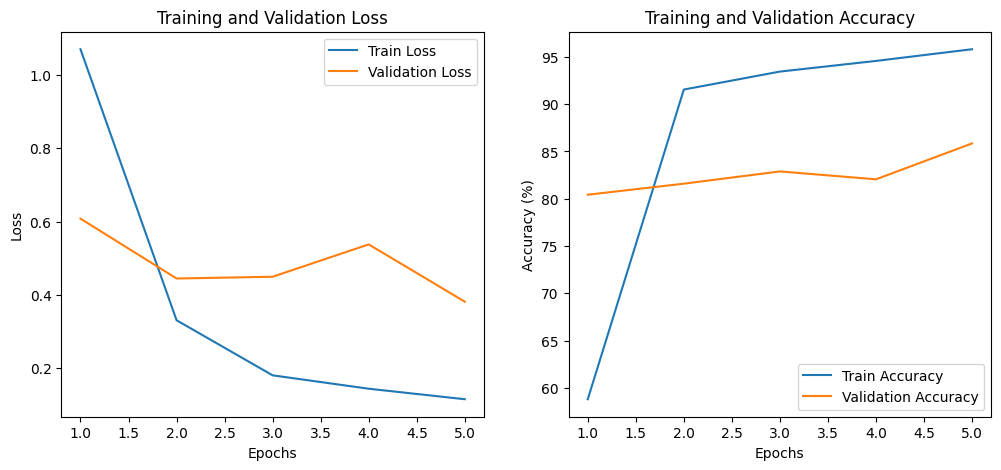

CNNModel(
  (conv1): Conv1d(1, 64, kernel_size=(16,), stride=(16,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (conv4): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7296, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=4, bias=True)
)

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

In [ ]:
# Mean Gradient 계산
mean_gradients = calculate_mean_gradients(model, train_loader, device, criterion)

In [ ]:
# 입력 예제 생성 (입력 채널 수와 길이에 맞게 수정)
input_channels = 1  # 모델의 입력 채널 수에 맞게 설정
input_length = 4000  # 입력 데이터의 길이에 맞게 설정
example_inputs = torch.randn(1, input_channels, input_length).to(device)

In [ ]:
# 모델 프루닝
prune_ratio = 0.92  # 프루닝할 비율 (예: 20%)
model = prune_model_based_on_mean_gradient(model, mean_gradients, prune_ratio, example_inputs)

Pruned 58 channels from conv1.
Pruned 29 channels from conv2.
Pruned 58 channels from conv3.
Pruned 117 channels from conv4.
Mean Gradient-based pruning applied. 262 channels pruned in total.


In [ ]:
# 프루닝 후 모델을 디바이스로 이동
model.to(device)

CNNModel(
  (conv1): Conv1d(1, 6, kernel_size=(16,), stride=(16,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(6, 3, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(3, 6, kernel_size=(5,), stride=(1,))
  (conv4): Conv1d(6, 11, kernel_size=(5,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=627, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=4, bias=True)
)

In [ ]:
# 옵티마이저 재설정
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)

Epoch 1/10: 100%|██████████| 788/788 [00:07<00:00, 104.21batch/s, accuracy=26.2, loss=1.38]


Epoch [1/10], Loss: 1.4065, Accuracy: 26.18%, Val Loss: 1.3806, Val Accuracy: 25.00%


Epoch 2/10: 100%|██████████| 788/788 [00:07<00:00, 109.07batch/s, accuracy=37.4, loss=1.29]


Epoch [2/10], Loss: 1.3534, Accuracy: 37.44%, Val Loss: 1.3176, Val Accuracy: 58.00%


Epoch 3/10: 100%|██████████| 788/788 [00:07<00:00, 101.94batch/s, accuracy=64.2, loss=1.13]


Epoch [3/10], Loss: 1.2333, Accuracy: 64.24%, Val Loss: 1.1266, Val Accuracy: 66.65%


Epoch 4/10: 100%|██████████| 788/788 [00:07<00:00, 111.33batch/s, accuracy=79.4, loss=0.85]


Epoch [4/10], Loss: 0.9727, Accuracy: 79.43%, Val Loss: 0.8662, Val Accuracy: 70.94%


Epoch 5/10: 100%|██████████| 788/788 [00:07<00:00, 102.13batch/s, accuracy=87.2, loss=0.623]


Epoch [5/10], Loss: 0.6938, Accuracy: 87.17%, Val Loss: 0.6792, Val Accuracy: 73.33%


Epoch 6/10: 100%|██████████| 788/788 [00:07<00:00, 108.47batch/s, accuracy=90.5, loss=0.535]


Epoch [6/10], Loss: 0.5107, Accuracy: 90.49%, Val Loss: 0.5435, Val Accuracy: 76.94%


Epoch 7/10: 100%|██████████| 788/788 [00:07<00:00, 104.96batch/s, accuracy=91.8, loss=0.335]


Epoch [7/10], Loss: 0.3914, Accuracy: 91.78%, Val Loss: 0.4830, Val Accuracy: 78.56%


Epoch 8/10: 100%|██████████| 788/788 [00:07<00:00, 102.96batch/s, accuracy=91.9, loss=0.432]


Epoch [8/10], Loss: 0.3112, Accuracy: 91.90%, Val Loss: 0.4379, Val Accuracy: 79.19%


Epoch 9/10: 100%|██████████| 788/788 [00:07<00:00, 111.03batch/s, accuracy=92.5, loss=0.202]


Epoch [9/10], Loss: 0.2596, Accuracy: 92.45%, Val Loss: 0.4553, Val Accuracy: 77.37%


Epoch 10/10: 100%|██████████| 788/788 [00:07<00:00, 101.07batch/s, accuracy=92.9, loss=0.245]


Epoch [10/10], Loss: 0.2252, Accuracy: 92.94%, Val Loss: 0.4541, Val Accuracy: 79.20%


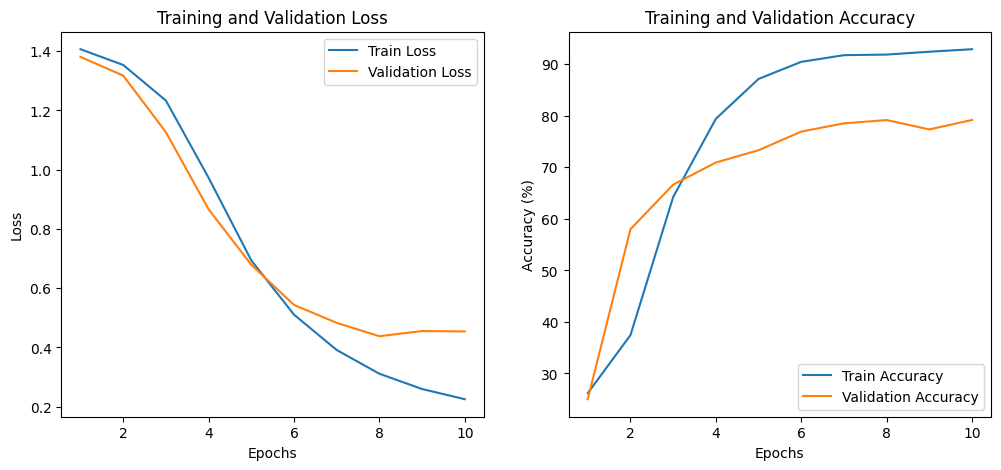

CNNModel(
  (conv1): Conv1d(1, 6, kernel_size=(16,), stride=(16,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(6, 3, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(3, 6, kernel_size=(5,), stride=(1,))
  (conv4): Conv1d(6, 11, kernel_size=(5,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=627, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=4, bias=True)
)

In [ ]:
# 파인튜닝 실행
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

In [ ]:
# 최종 테스트 평가
print("Final evaluation on the test set...")
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%')

Final evaluation on the test set...
Final Test Loss: 0.3900, Final Test Accuracy: 82.81%


In [ ]:
# 모델 평가 함수 (혼동 행렬 포함)
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # 혼동 행렬 계산
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    accuracy = 100 * correct / total
    return val_loss / total, accuracy, conf_matrix

Validation Loss: 0.0142
Validation Accuracy: 79.20%
Confusion Matrix:
[[ 589  690   70    1]
 [   0 1350    0    0]
 [ 239    0 1102    9]
 [   0    0  114 1236]]


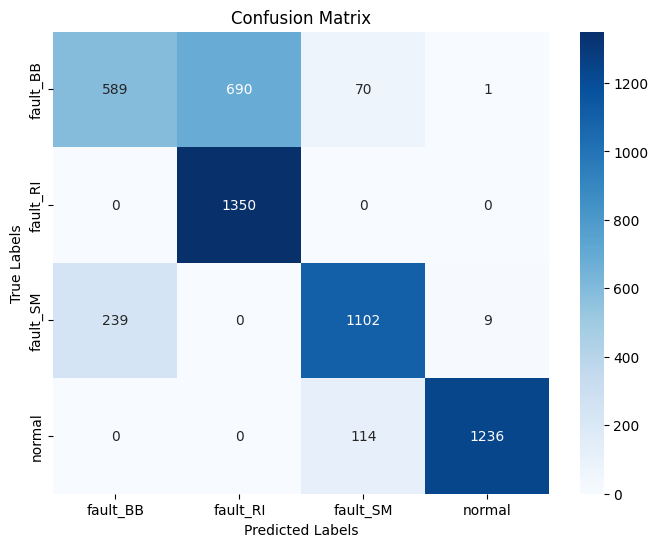

In [ ]:
# 혼동 행렬 시각화 함수
def plot_confusion_matrix(conf_matrix, label_encoder):
    categories = label_encoder.classes_  # LabelEncoder의 순서대로 클래스 레이블을 가져옴
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# 평가 및 시각화 예시
val_loss, val_accuracy, val_conf_matrix = evaluate_model(model, val_loader, criterion)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.2f}%")
print("Confusion Matrix:")
print(val_conf_matrix)

# 혼동 행렬 시각화
plot_confusion_matrix(val_conf_matrix, label_encoder)

In [ ]:
# 모델 크기 계산
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    model_size = (param_size + buffer_size) / 1024**2  # Convert to MB
    return model_size

In [ ]:
# 모델 크기 출력
model_size = get_model_size(model)
print(f'Model size: {model_size:.2f} MB')

Model size: 31.07 MB


In [ ]:
# 비제로 가중치 계산 함수
def count_nonzero_weights(model):
    nonzero_count = 0
    total_count = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            nonzero_count += torch.sum(param != 0).item()
            total_count += param.numel()
    return nonzero_count, total_count

In [ ]:
# 비제로 가중치 수 계산
nonzero_weights, total_weights = count_nonzero_weights(model)
print(f"Number of non-zero weights: {nonzero_weights}")
print(f"Total number of weights: {total_weights}")
print(f"Percentage of non-zero weights: {100 * nonzero_weights / total_weights:.2f}%")

Number of non-zero weights: 8145598
Total number of weights: 8145600
Percentage of non-zero weights: 100.00%


In [ ]:
from fvcore.nn import FlopCountAnalysis, flop_count_table

# FLOPs 계산 함수
def calculate_flops(model, input_size):
    model.eval()  # 평가 모드로 전환
    dummy_input = torch.randn(*input_size).to(device)  # 가짜 입력 생성
    flops = FlopCountAnalysis(model, dummy_input)
    return flops

# 입력 크기 정의 (배치 크기, 채널, 길이)
input_size = (1, 1, input_length)  # 배치 크기 1, 채널 1, input_length 사용

# FLOPs 계산
flops = calculate_flops(model, input_size)

# 결과 출력
print(f"Total FLOPs: {flops.total() / 1e6:.2f} MFLOPs")  # FLOPs를 MegaFLOPs 단위로 변환
print(flop_count_table(flops))

Total FLOPs: 8.22 MFLOPs
| module         | #parameters or shape   | #flops   |
|:---------------|:-----------------------|:---------|
| model          | 8.146M                 | 8.218M   |
|  conv1         |  0.102K                |  24K     |
|   conv1.weight |   (6, 1, 16)           |          |
|   conv1.bias   |   (6,)                 |          |
|  conv2         |  57                    |  6.642K  |
|   conv2.weight |   (3, 6, 3)            |          |
|   conv2.bias   |   (3,)                 |          |
|  conv3         |  96                    |  10.71K  |
|   conv3.weight |   (6, 3, 5)            |          |
|   conv3.bias   |   (6,)                 |          |
|  conv4         |  0.341K                |  37.95K  |
|   conv4.weight |   (11, 6, 5)           |          |
|   conv4.bias   |   (11,)                |          |
|  fc1           |  3.14M                 |  3.135M  |
|   fc1.weight   |   (5000, 627)          |          |
|   fc1.bias     |   (5000,)            

In [ ]:
# F1 스코어 계산
def calculate_f1_score(model, loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f"F1 Score: {f1:.4f}")

In [ ]:
print("\nCalculating F1 Score...")
calculate_f1_score(model, test_loader, device)


Calculating F1 Score...
F1 Score: 0.8251


In [ ]:
# 파라미터 수 계산 함수
def calculate_total_params(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params:,}")

In [ ]:
print("\nCalculating Total Parameters...")
calculate_total_params(model)


Calculating Total Parameters...
Total Parameters: 8,145,600


In [ ]:
# 자원 제한 설정 함수
def setup_limited_resources(cpu_only=True, num_threads=2):
    if cpu_only:
        device = torch.device("cpu")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # CPU 환경일 경우 스레드 수 제한
    if device.type == "cpu":
        torch.set_num_threads(num_threads)
        print(f"CPU 환경: 스레드 수를 {num_threads}개로 제한합니다.")
    else:
        print(f"GPU 환경: {torch.cuda.get_device_name(0)} 사용 중.")

    return device

In [ ]:
# 추론 시간 측정 함수
def measure_inference_time(model, input_data, device, iterations=100):
    model.eval()
    model.to(device)
    input_data = input_data.to(device)

    # 추론 시간 측정
    with torch.no_grad():
        start_time = time.time()
        for _ in range(iterations):
            _ = model(input_data)
        end_time = time.time()

    avg_time = (end_time - start_time) / iterations
    print(f"Average Inference Time: {avg_time * 1000:.2f} ms")
    return avg_time

In [ ]:
# 1. 모델 저장
torch.save(model, "trained_model.pth")
print("Model saved as 'trained_model.pth'")

# 2. CPU 환경 설정
device_cpu = setup_limited_resources(cpu_only=True, num_threads=2)

# 3. 모델 로드
model = torch.load("trained_model.pth", map_location=device_cpu)
model.to(device_cpu)
model.eval()
print("Model loaded and moved to CPU.")

Model saved as 'trained_model.pth'
CPU 환경: 스레드 수를 2개로 제한합니다.


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.CNNModel was not an allowed global by default. Please use `torch.serialization.add_safe_globals([CNNModel])` or the `torch.serialization.safe_globals([CNNModel])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
# 데이터 로더에서 샘플 데이터 가져오기
for input_data, _ in test_loader:
    break  # 첫 번째 배치만 가져옴

# 배치에서 첫 번째 샘플 선택 (배치 크기 1로 설정)
input_data = input_data[0:1].to(device_cpu)

In [ ]:
# 5. 제한된 환경에서 추론 시간 측정
print("\nMeasuring Inference Time on CPU...")
measure_inference_time(model, input_data, device_cpu, iterations=100)